# Flatiron School Data Science Project 4: Movie Recommendation System

## Intro

For this project, I trained two models to predict movie ratings for a given user. I used two datasets for this project, both sourced from MovieLens:
- The first was a small subset of MovieLens data, made up of 100k reviews from 600 users on 9k movies. I implemented this model using surprise locally
- The second was the entire MovieLens dataset, made up of 33M reviews from 330k users on 86k movies. I implemented this using the PySpark library on the Databricks platform.

## Model 1: 100k Reviews

First, let's import the packages we will use to model and visualize the data

In [45]:
import pandas as pd
import numpy as np
from surprise import Dataset, Reader, SVD
from surprise.model_selection import train_test_split, GridSearchCV
from surprise import accuracy
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
%matplotlib inline

Next, we'll read the data from the csv and store it in a surprise data structure so that our models can access it

In [ ]:
df = pd.read_csv('./data/ml-latest-small/ratings.csv')
reader = Reader(rating_scale=(0.5, 5.0))
data = Dataset.load_from_df(df[['userId', 'movieId', 'rating']], reader)

Then, we'll do our train-test split and fit a SVD model from surprise on the training data using the default parameters.

In [4]:
trainset, testset = train_test_split(data, test_size=.2, random_state=42)

In [5]:
model = SVD(n_factors=100, n_epochs=20, random_state=42)
model.fit(trainset)

In [10]:
predictions = model.test(testset)

rmse = accuracy.rmse(predictions)
mae = accuracy.mae(predictions)
fcp = accuracy.fcp(predictions)

RMSE: 0.8807
MAE:  0.6766
FCP:  0.6546


Our initial model is already performing pretty well, with an RMSE below 1 and a FCP above 50%. Now, let's do some hyperparameter tuning to try to improve the performance of the model.

In [14]:
param_grid = {
    "n_epochs": [15, 20, 25],
    "n_factors": [50, 100, 150, 200],
    "reg_all": [.01, .02, .05, .1]
}

gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'fcp'], cv=3)

gs.fit(data)

print(gs.best_score['fcp'])
print(gs.best_params['fcp'])

0.674193519147161
{'n_epochs': 25, 'n_factors': 200, 'reg_all': 0.1}


In [15]:
param_grid = {
    "n_epochs": [25, 30, 35],
    "n_factors": [200, 250, 300],
    "reg_all": [.1, .2, .3]
}

gs = GridSearchCV(SVD, param_grid, measures=['fcp'], cv=3)

gs.fit(data)

print(gs.best_score['fcp'])
print(gs.best_params['fcp'])

0.6776501704051636
{'n_epochs': 35, 'n_factors': 200, 'reg_all': 0.1}


Now that we've determined the optimal values for n_factors (200) and the regularization parameter (0.1), let's continue to increase the number of epochs until we start getting dimishing performance returns with our model.

In [16]:
param_grid = {
    "n_epochs": [35, 40, 45],
    "n_factors": [200],
    "reg_all": [.1]
}

gs = GridSearchCV(SVD, param_grid, measures=['fcp'], cv=3)

gs.fit(data)

print(gs.best_score['fcp'])
print(gs.best_params['fcp'])

0.6798024275918055
{'n_epochs': 45, 'n_factors': 200, 'reg_all': 0.1}


In [31]:
epoch_list = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 150, 200]
fcp_list = []
rmse_list = []
for epoch in epoch_list:
    model = SVD(n_factors=200, n_epochs=epoch, reg_all=.1, random_state=42)
    model.fit(trainset)
    predictions = model.test(testset)
    fcp_list.append(accuracy.fcp(predictions))
    rmse_list.append(accuracy.rmse(predictions))

FCP:  0.6526
RMSE: 0.8985
FCP:  0.6615
RMSE: 0.8864
FCP:  0.6657
RMSE: 0.8805
FCP:  0.6668
RMSE: 0.8766
FCP:  0.6687
RMSE: 0.8734
FCP:  0.6710
RMSE: 0.8705
FCP:  0.6722
RMSE: 0.8680
FCP:  0.6739
RMSE: 0.8657
FCP:  0.6744
RMSE: 0.8636
FCP:  0.6750
RMSE: 0.8619
FCP:  0.6763
RMSE: 0.8604
FCP:  0.6764
RMSE: 0.8592
FCP:  0.6766
RMSE: 0.8581
FCP:  0.6768
RMSE: 0.8573
FCP:  0.6774
RMSE: 0.8565
FCP:  0.6779
RMSE: 0.8559
FCP:  0.6775
RMSE: 0.8554
FCP:  0.6780
RMSE: 0.8550
FCP:  0.6785
RMSE: 0.8547
FCP:  0.6795
RMSE: 0.8544
FCP:  0.6816
RMSE: 0.8532
FCP:  0.6817
RMSE: 0.8532


Since it seems that the FCP and RMSE are levelling out, let's go ahead and plot them to see what we should set as the ideal number of epochs.

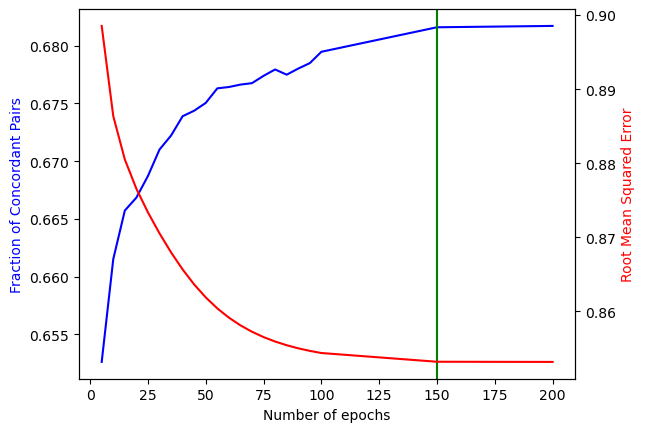

In [38]:
fig, ax1 = plt.subplots()

ax1.plot(epoch_list, fcp_list, c="b")
ax1.set_xlabel("Number of epochs")
ax1.set_ylabel("Fraction of Concordant Pairs", c="b")

ax2 = ax1.twinx()

ax2.plot(epoch_list, rmse_list, c="r")
ax2.set_ylabel("Root Mean Squared Error", c="r")

ax1.axvline(150, c='g')

plt.show()

As we can see, the number of epochs at which we start to experience diminishing returns is about 150. Now that we have all of our hyperparameters tuned, let's go ahead and create our final model.

In [29]:
model = SVD(n_factors=200, n_epochs=150, reg_all=.1, random_state=42)
model.fit(trainset)

In [30]:
predictions = model.test(testset)

rmse = accuracy.rmse(predictions)
mae = accuracy.mae(predictions)
fcp = accuracy.fcp(predictions)

RMSE: 0.8532
MAE:  0.6535
FCP:  0.6816


This model shows an improvement over the initial model, with RMSE being 0.03 lower and FCP being about 3% higher. Now, let's try to see if there is any relation between the movies and how that are rated in general. To determine this, we'll create a t-SNE model to reduce the dimensionality of the data and try to observe any clustering.

In [46]:
scaler = StandardScaler()
item_embeddings = scaler.fit_transform(model.qi)

In [47]:
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(item_embeddings)

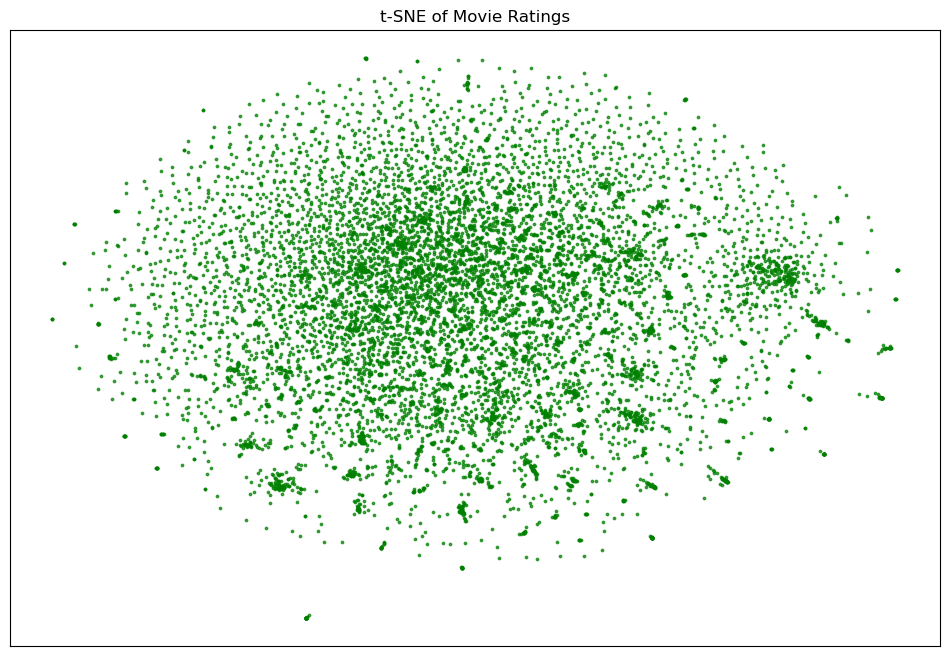

In [57]:
plt.figure(figsize=(12, 8))
plt.scatter(tsne_results[:, 0], tsne_results[:, 1], alpha=0.7, c="green", s=3)
plt.xticks([])
plt.yticks([])
plt.title('t-SNE of Movie Ratings')
plt.show()

Looking at this, it overall looks very noisy, but there are some small clusters that you can spot. These clusters represent movies that have similar rating patterns, which could be due to genre, overall user preference, or another factor. More research would be required to determine the exact cause of this clustering.

# Model 2: Big Data

*Note: This section of the notebook was compiled in a separate notebook on Databricks, so the cells will be lacking output. I have added the output beneath the cells in markdown blocks where appropriate.*

First, let's import the neccessary packages from PySpark to process and model the dataset

In [2]:
from pyspark.sql import SparkSession
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

Next, we will create a SparkSession, which will allow use to compile our Spark code

In [3]:
spark = SparkSession.builder.appName("Movie Recommender").getOrCreate()

25/03/21 13:39:14 WARN Utils: Your hostname, Matthews-MacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 10.129.2.122 instead (on interface en0)
25/03/21 13:39:14 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/03/21 13:39:15 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Now, we can start processing the data. First, we'll read it from the csv and use a PySpark function called repartition to split the data into smaller chunks based on userId. This will allow us to utilize parallelism to process the data more efficiently.

In [4]:
ratings_df = spark.read.csv("./data/ratings.csv", header=True, inferSchema=True)
ratings_df = ratings_df.repartition(500, "userId")

Now, we'll do our train test split, also creating a small train and test set to perform hyperparameter tuning in a shorter amount of time.

In [5]:
(training, test) = ratings_df.randomSplit([.8, .2], seed=42)
small_train = training.sample(.01, seed=42)
small_test = test.sample(.02, seed=42)

For our baseline model, we will train an ALS (Alternating Least Squares) model and then predict and output the RMSE 

In [ ]:
als = ALS(
    rank=10, 
    maxIter=5, 
    regParam=.1, 
    userCol="userId", 
    itemCol="movieId",
    ratingCol="rating", 
    coldStartStrategy="drop", 
    numUserBlocks=100, 
    numItemBlocks=100
)

als_model = als.fit(small_train)

25/03/21 12:01:16 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
25/03/21 12:01:18 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK


In [6]:
als_predictions = als_model.transform(small_test)

In [ ]:
als_predictions.printSchema()

root
 |-- userId: integer (nullable = true)
 |-- movieId: integer (nullable = true)
 |-- rating: double (nullable = true)
 |-- timestamp: integer (nullable = true)
 |-- prediction: float (nullable = false)



In [7]:
evaluator = RegressionEvaluator(
    metricName="rmse", 
    labelCol="rating",
    predictionCol="prediction"
)
rmse = evaluator.evaluate(als_predictions)
print(f"RMSE = {rmse}")

RMSE = 3.5300198578628437


Our initial model ended up having an RMSE of 3.53, which is very high. Once again, we will hyperparameter tune our model to try to improve the model.

In order to hyperparameter tune with PySpark, we have to first assign a model, parameter grid, and evaluator.

In [6]:
als = ALS(
    userCol="userId", 
    itemCol="movieId",
    ratingCol="rating", 
    coldStartStrategy="drop", 
    numUserBlocks=100, 
    numItemBlocks=100
)

In [7]:
paramGrid = ParamGridBuilder() \
    .addGrid(als.rank, [5, 10, 15]) \
    .addGrid(als.maxIter, [5, 10]) \
    .addGrid(als.regParam, [0.01, 0.1, 0.3]) \
    .addGrid(als.alpha, [0.5, 1.0]) \
    .build()

In [8]:
evaluator = RegressionEvaluator(
    metricName="rmse", 
    labelCol="rating",
    predictionCol="prediction"
)

Now, we pass those into our CrossValidator and fit. Note that this takes a very long time (hours) to complete on a local machine. To get around this constraint, I used a Databricks cluster, which is hosted on AWS infrastructure and is significantly faster than my computer :)

In [9]:
crossval = CrossValidator(
    estimator=als,
    estimatorParamMaps=paramGrid,
    evaluator=evaluator,
    numFolds=3,  # Number of folds for cross-validation
    parallelism=2  # Multithreading!
)

In [ ]:
cvmodel = crossval.fit(small_train)

Because I ran this on Databricks, it automatically started a MLFlow experiment where I could view the best model parameters once the fit had finished.

<img src="./pictures/Screenshot 2025-03-27 at 2.43.03 PM.png">

So, the best parameters for our ALS model are:
- alpha = 0.5
- maxIter = 10
- rank = 15
- regParam = 0.3

Now, let's look at the RMSE for our best model

In [ ]:
bestModel = cvmodel.bestModel

In [ ]:
predictions = bestModel.transform(small_test)

In [ ]:
rmse = evaluator.evaluate(predictions)
print(f"Root Mean Square Error (RMSE) on test data = {rmse}")

Output: *Root Mean Square Error (RMSE) on test data = 1.1940113767759664*

This is a noticable improvement over our original model. We can definitely lower this to be below 1 by training the model on the entire dataset.

In [ ]:
final_als = ALS(
    rank=15, 
    maxIter=10, 
    regParam=.3,
    alpha=.5, 
    userCol="userId", 
    itemCol="movieId",
    ratingCol="rating", 
    coldStartStrategy="drop", 
    numUserBlocks=100, 
    numItemBlocks=100
)

In [ ]:
final_als_model = final_als.fit(training)

In [ ]:
final_als_predictions = final_als_model.transform(test)

In [ ]:
evaluator = RegressionEvaluator(
    metricName="rmse", 
    labelCol="rating",
    predictionCol="prediction"
)
rmse = evaluator.evaluate(final_als_predictions)
print(f"RMSE = {rmse}")

Output: *RMSE = 0.9061115302474719*

As expected, training the model on the entire dataset improved the RMSE by a pretty significant amount. For good measure, let's also look at the FCP for this model. Pyspark doesn't have a built in way to calculate FCP, so let's write a function for it and then pass our predictions in

In [ ]:
from pyspark.sql import functions as F

def calculate_concordant_pairs(df, id_col, rank_col1, rank_col2):

    df_repartitioned = df.repartition(100, id_col)

    df_broadcast = F.broadcast(df_repartitioned)

    paired_df = df_repartitioned.alias('a').crossJoin(
        df_broadcast.alias('b')
    ).filter(
        F.col('a.' + id_col) == F.col('b.' + id_col)
    ).select(
        F.col('a.' + id_col).alias('id'),
        F.col('a.' + rank_col1).alias('rank1_a'),
        F.col('a.' + rank_col2).alias('rank2_a'),
        F.col('b.' + rank_col1).alias('rank1_b'),
        F.col('b.' + rank_col2).alias('rank2_b')
    )

    concordance_df = paired_df.withColumn(
        'concordant', 
        F.expr("""
            CASE WHEN 
                (rank1_a - rank1_b) * (rank2_a - rank2_b) > 0 
            THEN 1 ELSE 0 END
        """)
    )

    result_df = concordance_df.select(
        (F.sum('concordant') / F.count('*')).alias('concordant_fraction')
    )

    result = result_df.first()['concordant_fraction']

    return result

In [ ]:
fcp = calculate_concordant_pairs(
    final_als_predictions, 
    id_col='userId',
    rank_col1='prediction',
    rank_col2='rating')

print(f"Fraction of concordant pairs: {fcp}")

Output: *Fraction of concordant pairs: 0.5499609122804654*

This FCP vlaue is not too great, with 55% of the review pairs for a given user being accurately predicted.

## Next Steps

For future work on this project, I would take the following steps:
- Continue hyperparameter tuning on the big data model to achieve a higher FCP: Due to time and financial constraints, I was unable to complete more hyperparameter tuning on this model. I believe given the additional resources, I could improve this model to be significantly better than the SVD model.
- Investigate the clustering in the data: This could potentially be due to genre, user similarity, or a number of other factors. It would be interesting to investigate this in the future.